# Q Learning
Reference: https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict
from gridworld import GridworldEnv
from cliff_walking import CliffWalkingEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
mdp = 'cliff_walking'  # Set to the mdp problem to solve
assert mdp in {'grid_world', 'cliff_walking'}
if mdp == 'grid_world':
    env = GridworldEnv(shape=[4, 4])
else:
    env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [5]:
start_time = time.time()
Q, stats = q_learning(env, 500)
end_time = time.time()
print('Time elapsed: {} seconds'.format(end_time - start_time))

Episode 500/500.Time elapsed: 0.5002050399780273 seconds


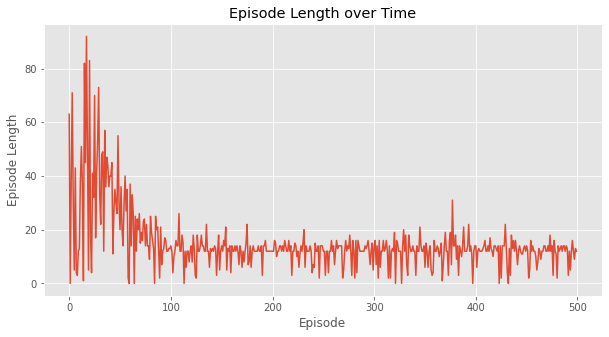

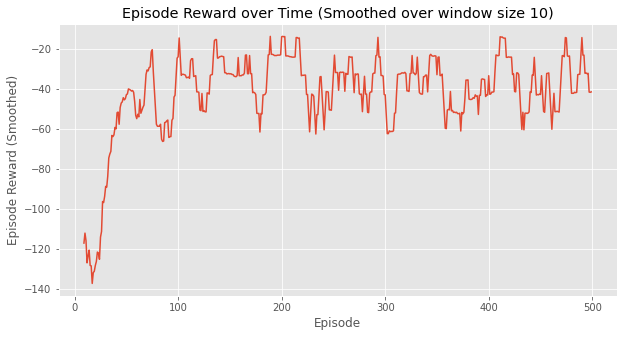

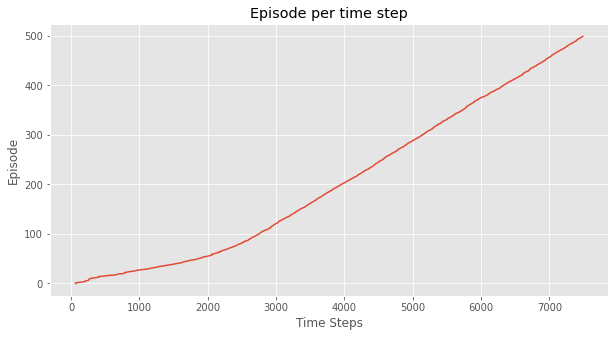

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)

In [7]:
q_values = np.vstack(tuple(Q[k] for k in sorted(Q.keys())))

print("Q (state-action) values:")
print(q_values)

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(q_values, axis=1), env.shape))

print("Value Function:")
print(np.max(q_values, axis=1))

print("Reshaped Grid Value Function:")
print(np.max(q_values, axis=1).reshape(env.shape))

Q (state-action) values:
[[-12.17550349 -12.25902431 -12.35209586 -12.34580949]
 [-12.         -11.69452014 -11.81869958 -11.61597048]
 [-10.93216959 -10.88725332 -11.40615573 -11.0669349 ]
 [ -9.95869446 -10.06974327 -10.27065696 -10.01103178]
 [ -9.5         -9.26195374  -9.2320719   -9.19600414]
 [ -8.8430195   -8.42987249  -8.48211807  -8.50485239]
 [ -7.59063721  -7.57304687  -7.70739121  -8.42201989]
 [ -7.14250148  -6.74470341  -6.70807805  -7.4624847 ]
 [ -6.          -5.78777551  -5.92492026  -6.73130691]
 [ -4.859375    -4.88589547  -4.8808244   -5.76070963]
 [ -4.18115234  -3.96834619  -3.97578062  -4.56770182]
 [ -3.          -3.          -2.99881577  -3.4140625 ]
 [-12.65741298 -12.74808215 -12.68005483 -12.78525978]
 [-12.13904735 -11.87723395 -11.93162608 -12.53543822]
 [-11.39289382 -10.94791361 -10.96937491 -11.83257042]
 [-10.30006689  -9.972563    -9.98171537 -10.7688129 ]
 [ -9.09741046  -8.98996974  -8.99233306 -10.41089403]
 [ -8.04105515  -7.99719499  -7.99677608